# Load data set from Kaggle

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"","key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
! kaggle competitions download -c new-york-city-taxi-fare-prediction

 99% 1.54G/1.56G [00:11<00:00, 129MB/s]
100% 1.56G/1.56G [00:11<00:00, 143MB/s]


In [ ]:
! mkdir 'nyc-data-set'

In [ ]:
!unzip "/content/new-york-city-taxi-fare-prediction.zip" -d "/content/nyc-data-set"

Archive:  /content/new-york-city-taxi-fare-prediction.zip
  inflating: /content/nyc-data-set/GCP-Coupons-Instructions.rtf  
  inflating: /content/nyc-data-set/sample_submission.csv  
  inflating: /content/nyc-data-set/test.csv  
  inflating: /content/nyc-data-set/train.csv  


# INPUT

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf

In [ ]:
# Read file

df = pd.read_csv('/content/nyc-data-set/train.csv', parse_dates=['pickup_datetime'], nrows=500000)

# Exploratory Data Analysis

In [ ]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7


`fare_amount` is the tartget variable we are trying to predict

**Let's visualize the longtitude and latitude, restricted only in NYC**

In [ ]:
# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

# Let's retrict the data to only contain the NYC pickup and dropoff position in
df2 = df.copy(deep=True)
for long_ in ['pickup_longitude', 'dropoff_longitude']:
    df2 = df2[(df2[long_] > nyc_min_longitude) & (df2[long_] < nyc_max_longitude)]

for lat_ in ['pickup_latitude', 'dropoff_latitude']:
    df2 = df2[(df2[lat_] > nyc_min_latitude) & (df2[lat_] < nyc_max_latitude)]

In [ ]:
# Add some landmarks of NYC into the scatterplot (from Google)

landmarks = {'JFK Airport': (-73.78, 40.643),
             'Laguardia Airport': (-73.87, 40.77),
             'Midtown': (-73.98, 40.76),
             'Lower Manhattan': (-74.00, 40.72),
             'Upper Manhattan': (-73.94, 40.82),
             'Brooklyn': (-73.95, 40.66)}

In [ ]:
def plot_lat_long(df, landmarks, points='Pickup'):
    plt.figure(figsize = (12,12)) # set figure size
    if points == 'pickup':
        plt.plot(list(df.pickup_longitude), list(df.pickup_latitude), 
                 '.', markersize=1)
    else:
        plt.plot(list(df.dropoff_longitude), list(df.dropoff_latitude), 
                 '.', markersize=1)

    for landmark in landmarks:
        plt.plot(landmarks[landmark][0], landmarks[landmark][1], 
                '*', markersize=15, alpha=1, color='r') 
        plt.annotate(landmark, (landmarks[landmark][0]+0.005, 
                     landmarks[landmark][1]+0.005), color='r', 
                     backgroundcolor='w') 
 
    plt.title("{} Locations in NYC Illustrated".format(points))
    plt.grid(None)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()

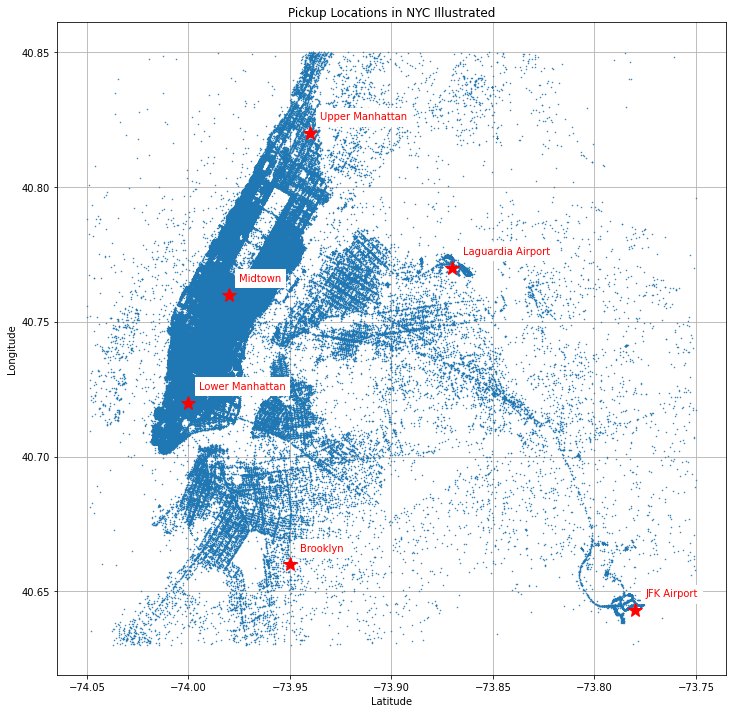

In [ ]:
plot_lat_long(df2, landmarks, points='Pickup')

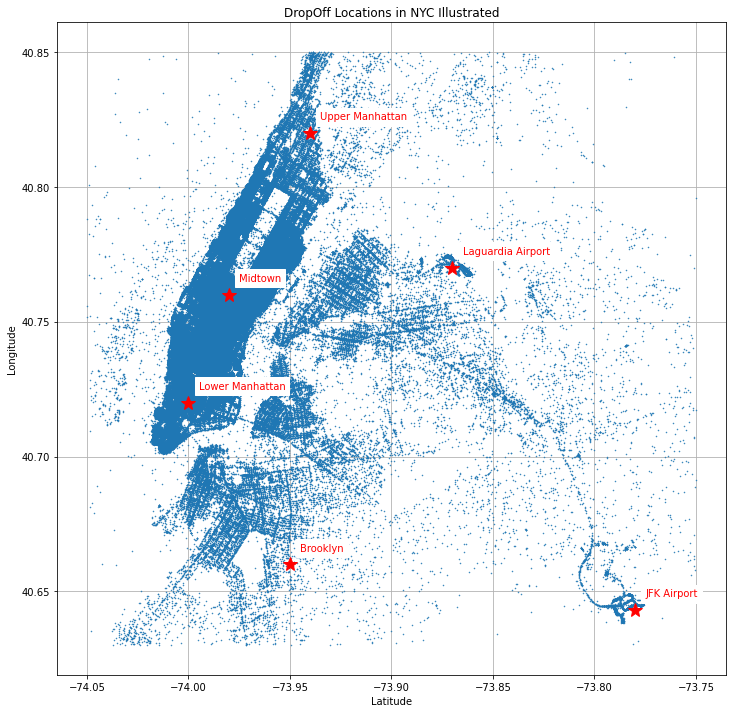

In [ ]:
plot_lat_long(df2, landmarks, points='DropOff')

**Explore number of ride (ridership) by day/hour**

In [ ]:
# Let's separate the `pickup_date_time` into its repsective day, hour

df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

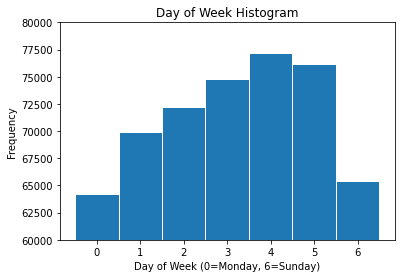

In [ ]:
# Plot a histogram to explore number of rides throughout the week

df['day_of_week'].plot.hist(bins=np.arange(8)-0.5, ec='white', ylim=(60000,80000))
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.title('Day of Week Histogram')
plt.show()

The concentration is not evenly distributed. In fact, most of the rides are booked within weekdays. Sunday observes a fall on the number of ridership.

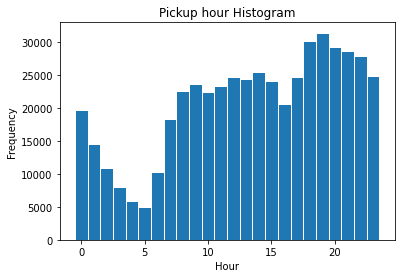

In [ ]:
# Plot a histogram to explore number of rides by hour

df['hour'].plot.hist(bins=np.arange(25)-0.5, ec='white')
plt.xlabel('Hour')
plt.title('Pickup hour Histogram')
plt.show()

The number of rides peak during night time, from 7PM to 12PM, in contrast with the working time.

# Data Preprocessing

First take a look at the missing values

In [ ]:
df_copy = df.copy()

In [ ]:
df = df_copy

In [ ]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
year                 0
month                0
day                  0
day_of_week          0
hour                 0
dtype: int64

In [ ]:
# As the number is very small, let's remove those records
df.dropna(inplace=True)

In [ ]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
count,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,11.358182,-72.520091,39.920350,-72.522435,39.916526,1.683445,2011.739129,6.268617,15.684239,3.042020,13.510843
std,9.916069,11.856446,8.073318,11.797362,7.391002,1.307391,1.860897,3.437798,8.681092,1.949243,6.511596
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992047,40.734916,-73.991382,40.734057,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000


Easy to notice that there are problems with the data in `fare_amount`, `passenger_count` and `longtitude / latitude`

- First, let's take a look at `fare_amount`

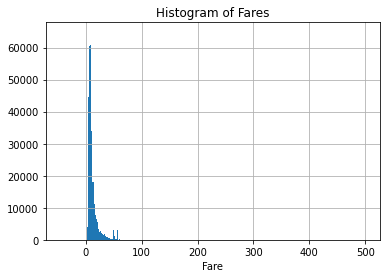

In [ ]:
df['fare_amount'].hist(bins=500)
plt.xlabel("Fare")
plt.title("Histogram of Fares")
plt.show()

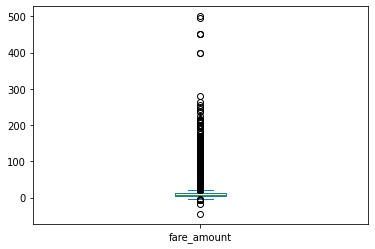

In [ ]:
df['fare_amount'].plot.box()

In [ ]:
# Let's explore number of records by the amount of fare
print('Number of records has value of fare ranging:')
for i in range(0, 600, 100):
  count = (df['fare_amount'].between(i, i+99)).sum()
  print(f'from {i} to {i+99}: {count}')

Number of records has value of fare ranging:
from 0 to 99: 499740
from 100 to 199: 199
from 200 to 299: 23
from 300 to 399: 0
from 400 to 499: 6
from 500 to 599: 1


In [ ]:
# Roughly 229 records having fare_amount larger than 100 dollars, which is pretty small compared to the whole dataset. 
# Let's remove these rows.
df = df[df['fare_amount'].between(0.1,100)]

- Now, let's move to `passenger_count`

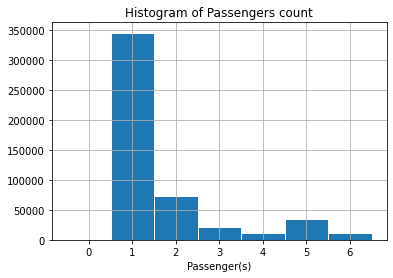

In [ ]:
df['passenger_count'].hist(bins=np.arange(8)-0.5, ec='white')
plt.xlabel("Passenger(s)")
plt.title("Histogram of Passengers count")
plt.show()

In [ ]:
# Number of 0 passenger
(df['passenger_count'] == 0).sum()

1791

In [ ]:
df['passenger_count'].mode()[0]

1

In [ ]:
# 1791 records have 0 value in `passenger_count`, let's replace these values with the `mode` value of columns.
df.loc[(df['passenger_count'] == 0) | (df['passenger_count'].isnull()),'passenger_count'] = df['passenger_count'].mode()[0]

- Finally, we will handle our `longtitude / latitude`

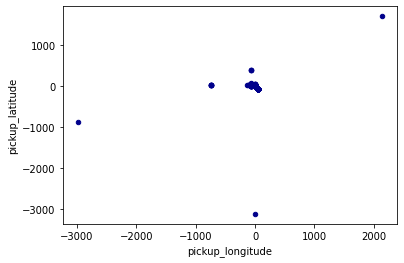

In [ ]:
# We will use a scatterplot to visualize how data is distributed

# For the Pickup locations
df[['pickup_longitude', 'pickup_latitude']].plot.scatter(x='pickup_longitude',y='pickup_latitude',c='DarkBlue')


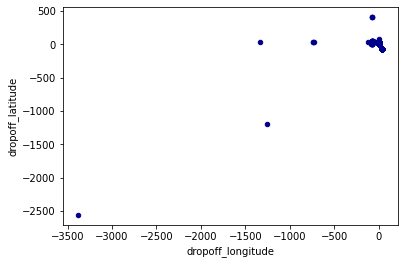

In [ ]:
# For the Dropoff locations
df[['dropoff_longitude', 'dropoff_latitude']].plot.scatter(x='dropoff_longitude',y='dropoff_latitude',c='DarkBlue')

In [ ]:
# As we can observe, the min latitude is -2500, the min longtitude is -3000, which is out of the Earth
# Let's restrict out data to only in NYC

# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

# only consider locations within NYC
for long in ['pickup_longitude', 'dropoff_longitude']:
    df = df[(df[long] > nyc_min_longitude) & (df[long] <
                                              nyc_max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df = df[(df[lat] > nyc_min_latitude) & (df[lat] < 
                                            nyc_max_latitude)].reset_index()

In [ ]:
df.columns

Index(['level_0', 'index', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'year', 'month', 'day',
       'day_of_week', 'hour'],
      dtype='object')

In [ ]:
df = df.drop(['level_0', 'index'], axis=1).reset_index()

In [ ]:
df = df.drop(['index'], axis=1)

In [ ]:
# Let's take the look at the final dataset
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
count,483423.000000,483423.000000,483423.000000,483423.000000,483423.000000,483423.000000,483423.000000,483423.000000,483423.000000,483423.000000,483423.000000
mean,11.014640,-73.975684,40.750901,-73.974590,40.751157,1.687125,2011.737878,6.269069,15.679064,3.040826,13.523901
std,8.770986,0.033540,0.026220,0.032034,0.028471,1.304103,1.862997,3.440120,8.680919,1.948240,6.492070
min,2.500000,-74.049288,40.630097,-74.049897,40.630056,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992262,40.736642,-73.991547,40.735920,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.982097,40.753380,-73.980677,40.753855,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.968485,40.767395,-73.965803,40.768242,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000
max,100.000000,-73.750322,40.849922,-73.750061,40.849988,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000


After finishing our Data Preprocessing, we have eliminated nearly 17000 rows, which is about 3% of the dataset.  

# Feature Engineering

## datetime features

In [ ]:
# let's take a look at column `pickup_datetime`
df['pickup_datetime']

0        2009-06-15 17:26:21+00:00
1        2010-01-05 16:52:16+00:00
2        2011-08-18 00:35:00+00:00
3        2012-04-21 04:30:42+00:00
4        2010-03-09 07:51:00+00:00
                    ...           
483418   2015-05-07 18:45:12+00:00
483419   2010-09-13 12:11:34+00:00
483420   2014-08-25 00:22:20+00:00
483421   2015-01-12 12:17:32+00:00
483422   2010-04-12 23:46:58+00:00
Name: pickup_datetime, Length: 483423, dtype: datetime64[ns, UTC]

In [ ]:
# Let's make some new features out of it
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

In [ ]:
df.drop(columns=['pickup_datetime'], axis=1, inplace=True)

## Geolocation features

The dataset contains no feature with information about the distance of each rider. 

In [ ]:
# A function to calculate distance using Euclidean Distance
def euc_distance(lat1, long1, lat2, long2):
  return(((lat1 - long1)**2 + (lat2 - long2)**2)**0.5)

In [ ]:
df['distance'] = euc_distance(df['pickup_latitude'],
                              df['pickup_longitude'],
                              df['dropoff_latitude'],
                              df['dropoff_longitude'])

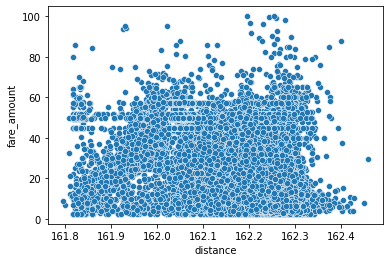

In [ ]:
sns.scatterplot(y=df['fare_amount'], x=df['distance'])

- It is noticable that there are 3 straight lines at the middle of the plot. It suggests that there might be a fixed `fare_amount` for some particular route related to Airports.
- For our model to regconize this pattern, we will create new features measuring the distance from pickup and dropoff location to these 3 airports

In [ ]:
airports = {'JFK_Airport': (-73.78,40.643),
            'Laguardia_Airport': (-73.87, 40.77),
            'Newark_Airport' : (-74.18, 40.69)}

for airport in airports:
    df['pickup_dist_' + airport] = euc_distance(df['pickup_latitude'],
                                                df['pickup_longitude'], 
                                                airports[airport][1], 
                                                airports[airport][0])
    df['dropoff_dist_' + airport] = euc_distance(df['dropoff_latitude'], 
                                                 df['dropoff_longitude'],
                                                 airports[airport][1], 
                                                 airports[airport][0])

In [ ]:
df[['key', 'pickup_longitude', 'pickup_latitude', 
          'dropoff_longitude', 'dropoff_latitude', 
          'pickup_dist_JFK_Airport',
          'dropoff_dist_JFK_Airport']].head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport
0,2009-06-15 17:26:21.0000001,-73.844311,40.721319,-73.841610,40.712278,161.919444,161.911137
1,2010-01-05 16:52:16.0000002,-74.016048,40.711303,-73.979268,40.782004,162.033910,162.057929
2,2011-08-18 00:35:00.00000049,-73.982738,40.761270,-73.991242,40.750562,162.045704,162.044144
3,2012-04-21 04:30:42.0000001,-73.987130,40.733143,-73.991567,40.758092,162.028899,162.049706
4,2010-03-09 07:51:00.000000135,-73.968095,40.768008,-73.956655,40.783762,162.040107,162.043162


In [ ]:
# See that key is the primary key of the dataset and should be removed
df = df.drop(['key'], axis=1)

# Regularization (Feature scaling)

In [ ]:
df_scaled.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport,pickup_dist_Laguardia_Airport,dropoff_dist_Laguardia_Airport,pickup_dist_Newark_Airport,dropoff_dist_Newark_Airport,fare_amount
0,3.916953,-1.128237,4.151241,-1.365563,-0.528105,-1.469611,-0.078215,-0.078225,-1.560808,0.535438,-4.922994,-3.735176,-4.218505,-3.735177,-4.218505,-3.735178,-4.218506,4.5
1,-1.203466,-1.510240,-0.146048,1.083480,-0.528105,-0.932841,-1.531654,-1.230178,-1.047523,0.381404,0.536779,0.017684,0.872321,0.017683,0.872322,0.017683,0.872322,16.9
2,-0.210313,0.395465,-0.519842,-0.020883,0.237714,-0.396071,0.503161,0.267361,-0.020955,-2.083144,0.495162,0.404372,0.394229,0.404372,0.394229,0.404372,0.394229,5.7
3,-0.341263,-0.677278,-0.529988,0.243599,-0.528105,0.140699,-0.659591,0.612947,1.005613,-1.467007,0.260295,-0.146622,0.587126,-0.146622,0.587126,-0.146623,0.587127,7.7
4,0.226275,0.652448,0.559865,1.145227,-0.528105,-0.932841,-0.950279,-0.769397,-1.047523,-1.004904,0.357717,0.220856,0.360169,0.220856,0.360169,0.220856,0.360169,5.3


In [ ]:
# Let's make a copy of our dataset, so that we can easily recover to the original values
df_prescaled = df.copy()

In [ ]:
df_scaled = df.drop(['fare_amount'], axis=1)

In [ ]:
df_scaled = scale(df_scaled)

In [ ]:
cols = df.columns.tolist()
cols.remove('fare_amount')
df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df.index)
df_scaled = pd.concat([df_scaled, df['fare_amount']], axis=1)
df = df_scaled.copy()

In [ ]:
X = df.loc[:, df.columns != 'fare_amount'] 
y = df.loc[:, 'fare_amount']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation= 'relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dense(8, activation= 'relu'))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               2304      
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 8)                 264       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 12,913
Trainable params: 12,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1)

12086/12086 [==============================] - 29s 2ms/step - loss: 14.3328


In [ ]:
def predict_random(df_prescaled, X_test, model):
    sample = X_test.sample(n=1, random_state=np.random.randint(low=0, 
                                                              high=10000))
    idx = sample.index[0]

    
    actual_fare = df_prescaled.loc[idx,'fare_amount']
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
                 'Saturday', 'Sunday']
    day_of_week = day_names[df_prescaled.loc[idx,'day_of_week']]
    hour = df_prescaled.loc[idx,'hour']
    predicted_fare = model.predict(sample)[0][0]
    rmse = np.sqrt(np.square(predicted_fare-actual_fare))

    print("Trip Details: {}, {}:00hrs".format(day_of_week, hour))  
    print(f"Index number: {idx}")
    print("Actual fare: ${:0.2f}".format(actual_fare))
    print("Predicted fare: ${:0.2f}".format(predicted_fare))
    print("RMSE: ${:0.2f}".format(rmse))

In [ ]:
predict_random(df_prescaled, X_test, model)

Trip Details: Tuesday, 20:00hrs
Index number: 329446
Actual fare: $7.50
Predicted fare: $7.94
RMSE: $0.44


In [ ]:
predict_fare = model.predict(X_test.loc[350407, :].to_frame().T)[0][0]
print(predict_fare)

17.241505


In [ ]:
# Let's test the result with records that have fare_amount fixed (=52)
y_test[y_test==52].index

Int64Index([261846, 369585, 215319, 342297, 469636, 112376, 159297, 276021,
            363801, 126652,
            ...
            428749, 217636, 130139,  33997, 219995, 368014,  55957, 385596,
            456926, 311641],
           dtype='int64', length=217)

In [ ]:
for idx in y_test[y_test==52].index:
  predict_fare = model.predict(X_test.loc[idx, :].to_frame().T)[0][0]
  print(idx, predict_fare)

261846 53.425518
369585 56.737785
215319 48.961864
342297 50.536594
469636 53.567165
112376 11.31508
159297 52.106396
276021 55.770325
363801 58.798344
126652 56.216557
350407 17.241505
279969 50.25601
367497 56.20625
144793 51.15653
240389 58.448524
207313 58.80987
411133 55.109673
286597 57.64745
28907 55.181454
197326 57.2921
123915 58.670322
392088 53.638992
103149 14.488723
202473 54.948578
140774 52.93481
32406 52.13477
433904 50.05856
160967 58.9013
450687 55.053253
235352 57.57575
158989 54.966816
199339 55.24007
35035 58.47468
263717 53.106438
50845 52.7704
89619 9.463904
108485 52.37058
268352 47.507816
209251 52.508057
50655 56.458206
472037 50.564346
74184 56.058975
8427 4.8883867
392131 57.18786
290371 32.10045
381178 55.722183
52841 50.28593
443061 60.57625
148728 54.880203
211485 51.898968
62507 52.06013
350162 60.2594
470385 53.71715
61900 56.01774
25284 54.33595
418217 6.481066
420953 59.80528
183709 17.540668
410355 6.4562473
407905 59.147316
314056 52.489517
350788 5

The model has done a pretty good job at predicting those ridership near one of the 3 airports (very close to $52)